In [28]:
jqdatasdk??

Object `jqdatasdk` not found.


In [27]:
!pip install jqdatasdk

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for jqdatasdk from https://files.pythonhosted.org/packages/63/6b/4bc2747558a03d006f4bdafc3413325fb59fb1dc1427ab54b3e3272fa1c1/jqdatasdk-1.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for SQLAlchemy>=1.2.8 from https://files.pythonhosted.org/packages/fb/2e/015ad3b62da87717666e6ac2959085fda651d667f572f86490008e07c0d8/SQLAlchemy-2.0.20-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for pymysql>=0.7.6 from https://files.pythonhosted.org/packages/e5/30/20467e39523d0cfc2b6227902d3687a16364307260c75e6a1cb4422b0c62/PyMySQL-1.1.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612

In [15]:
import pandas as pd
import time
from tqdm import tqdm
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import cProfile
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings("ignore")

class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(d2l.DATA_URL+ 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
            
    def preprocess(self):
        label = 'SalePrice'
        features = pd.concat((self.raw_train.drop(columns=['Id',label]),
                              self.raw_val.drop(columns=['Id'])))
        numeric_features = features.dtypes[features.dtypes!='object'].index
        features[numeric_features] = features[numeric_features].apply(lambda x: (x-x.mean())/x.std())
        features[numeric_features].fillna(0)
        features = pd.get_dummies(features, dummy_na=True)
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train[label] = self.raw_train[label]
        self.val = features[self.raw_train.shape[0]:].copy()
        
    def get_dataloader(self, train):
        label = 'SalePrice'
        data = self.train if train else self.val
        if label not in data:
            return
        get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)
        # tensors = (get_tensor(data.drop(columns=[label])),
        #            torch.log(get_tensor(data[label])).reshape(-1,1))
        tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
        return self.get_tensorloader(tensors, train)
    
def k_fold_data(data,k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j*fold_size,(j+1)*fold_size)
        rets.append(KaggleHouse(data.batch_size,data.train.drop(index=idx),data.train.iloc[idx]))
    return rets

def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data,k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0:
            model.board.display=False
        trainer.fit(model,data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

In [18]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)
data.preprocess()
print(data.train.shape)
print(data.val.shape)

(1460, 81)
(1459, 80)
(1460, 332)
(1459, 331)


In [23]:
# X,y = next(iter(data.get_dataloader(train=True)))

(nan, 0)

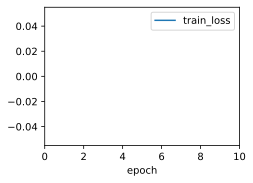

In [26]:
model = d2l.LinearRegression(0.01)
model.board.yscale='log'
trainer.fit(model,data)

average validation log mse = nan


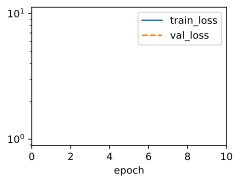

In [19]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), torch.float32)) for model in models]
ensemble_preds = torch.exp(torch.cat(preds,1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

# 1. Submit your predictions for this section to Kaggle. How good are they?



# 2. Is it always a good idea to replace missing values by a mean? Hint: can you construct a situation where the values are not missing at random?



# 3. Improve the score by tuning the hyperparameters through K-fold cross-validation.



# 4. Improve the score by improving the model (e.g., layers, weight decay, and dropout).



# 5. What happens if we do not standardize the continuous numerical features as we have done in this section?